In [1]:
from groo.groo import get_root
root_dir = get_root(".root_dir_covid")

import os

print(root_dir)
import sys
sys.path.append(os.path.join(root_dir, "covid-fear", "scripts"))


import numpy as np
import pandas as pd
from cov_functions import *
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')




# load main dataset
df = pd.read_csv(os.path.join(root_dir, "data", "full_dataset_only_complete.csv"))
behdf = pd.read_csv(os.path.join(root_dir, "data", "task_data", "task_data_summarized.csv"))
behdf = behdf.set_index("subid")

idlink = pd.read_csv(os.path.join(root_dir, "data", "berlin_lab_participants.csv"))
idlink = idlink.set_index("subID")




##### VERY IMPORTANT ####
df["state_severity"] = df["deaths14_norm_unsmooth"]
df["cases"] = df["cases14_norm_unsmooth"]
df["deaths"] = df["deaths14_norm_unsmooth"]

/data/drive/postdoc/Project4_covid


In [2]:
beh_columns = ['mflr', 'updates', 'prob_harm', 'prob_safe',
       'prob_acq', 'prob_ext', 'prob_diff', 'steepness', 'switchpoint', 'meaningful', 'oddball', 'oddball_diff', 'sh_mflr', 'nosh_mflr', 'shnosh_diff_mflr']

In [3]:
behdf = behdf.join(idlink, how='left')
behdf = behdf.set_index("PROLIFICID")

behdf["prob_diff"] = behdf["prob_acq"] - behdf["prob_ext"]

key = pd.read_csv(os.path.join(root_dir,"data", "main_key.csv" ))
key = key.set_index("old_key")

behdf = behdf.join(key, how='left')
behdf = behdf.set_index("new_key")

behdf_raw = behdf


In [4]:
### Meta parameters
corr_type = "pearson" # used in all analyses

no_covid_factors = 3
if no_covid_factors ==6:
    factors =[ "F1_Close_Person_Worry","F2_Anxiety_Avoidance", "F3_Economic_Impact_Worry", "F4_Prob_Estimates", "F5_Worry", "F6_Skepticism"]
elif no_covid_factors==3:
    factors = ["F1_CovidAnxietyWorry", "F2_CovidProbabilityEsts", "F3_Economic"]
    
print("State seveirty NaNs: "+str(df["state_severity"].isna().sum())+" out of entries: "+ str(df.shape[0]))

no_trait_factors = 3
if no_trait_factors == 6:
        trait_factor_names = ["TF1_Self_Consciousness", "TF2_Positive", "TF3_Catastrophizing",  "TF4_Physiological_Anx",  "TF5_Depression",  "TF6_Cognitive_Anx"]
elif no_trait_factors==5:
    trait_factor_names = ["TF1_Worry", "TF2_Self_Worth", "TF3_Catastrophizing",  "TF4_Anxiety",  "TF5_Depression"]    
elif no_trait_factors==3:
        trait_factor_names = ["TF3_NegativeAffect", "TF2_PhysiolAnx", "TF1_CognAnxDepr"]
elif no_trait_factors==4:
        trait_factor_names = ["TF3_NegativeAffect", "TF2_PhysiolAnx", "TF1_CognAnxDepr","stai_ta"]
elif no_trait_factors==99:
    trait_factor_names = ["stai_ta", "sticsa_ta", "cat", "bdi"] 

vars = trait_factor_names+factors+["q6_close_person_infdied", 
                                   "q6_work_home", 
                                   "q6_apply_soc_dist", 
                                   "q6_risk_group",
                                   "q6_houshold_membs", 
                                   "q6_media_freq_num", 
                                   "q6_media_valence", 
                                   "q7_worry_infdie", 
                                   "q7_worry_econ_impact", 
                                   "q7_worry_insuf_help", 
                                   "q7_worry_shortage", 
                                   "q7_period_rel_danger",
                                   "q7_period_rel_safety", 
                                   "q7_safety_danger_diff",
                                   "q7_people_overreact",  
                                   "q7_vir_not_as_dangerous", 
                                   "q7_avoid",
                                   "q7_covid_anxiety",
                                   "q7_anx_touching_surf", 
                                   "q8_prob_inf_me", 
                                   "obj_severity",
                                   "covid_worry", 
                                   "avoid_beh",
                                   "avoid_anx", 
                                   "prob_est", 
                                   "covid_thoughts",
                                   "bdi",
                                   #"q7_worry_econ_impact",
                                   #"stai_ta", 
                                   "sticsa_cog_ta", 
                                   "sticsa_som_ta", 
                                   "deaths7_norm", 
                                   "worry-prob", 
                                   "worryhealth",
                                   "affheallth-econ-worry", 
                                   "covid_cases_est_diff", 
                                   "deaths",  
                                   "cases", 
                                   "memory_worry_infected_baselined", 
                                   "memory_prob_infected_baselined", 
                                   "memory_worry_over_prob"]

addvars = [x+"_ms" for x in trait_factor_names]

State seveirty NaNs: 191 out of entries: 5825


In [5]:
data = df.groupby(by=["PROLIFICID"]+addvars)[vars].mean().reset_index().set_index("PROLIFICID")


behdf = behdf.loc[:,beh_columns].join(data, how='left')


   

### Add learning rates

In [6]:
alp = pd.read_csv(os.path.join(root_dir, "output", "covid_alphas.csv"))
alp = alp.set_index("PROLIFICID").drop(columns=["stai_ta"])

behdf = behdf.join(alp, how='left')

In [7]:
behdf["log_steepness"] = np.log(behdf["steepness"])

<AxesSubplot:>

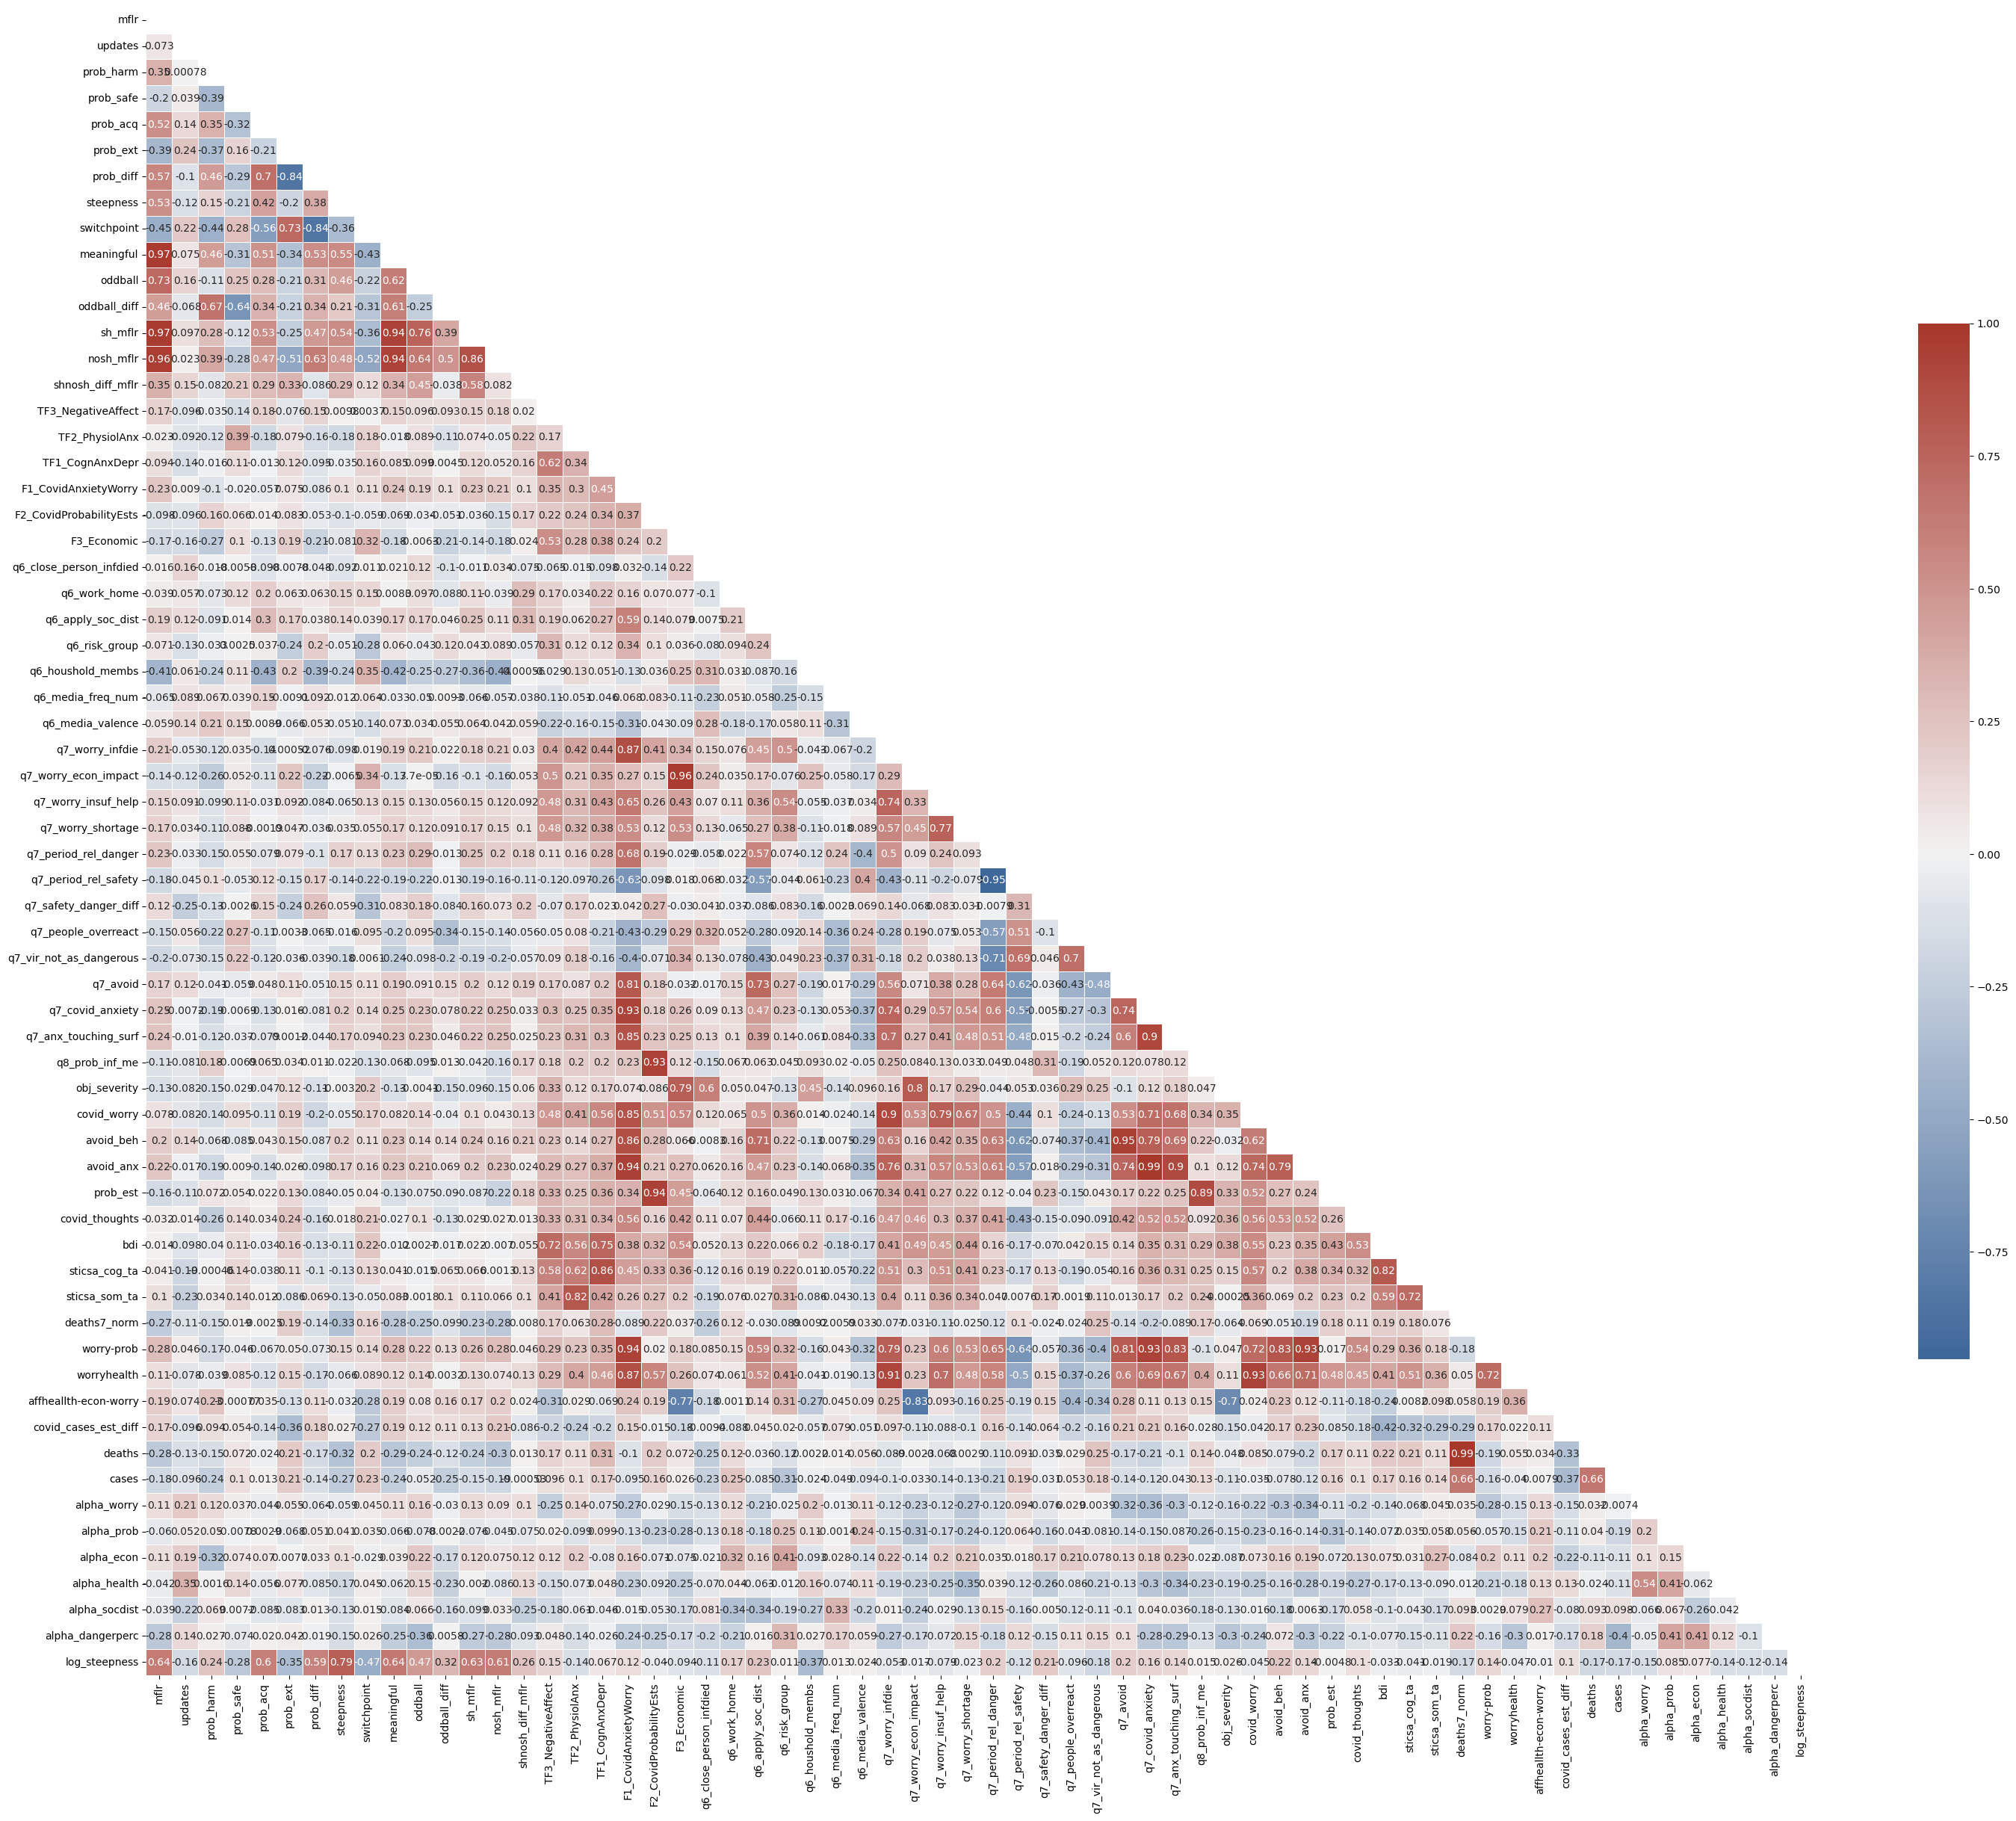

In [8]:

# calculate correlation matrix
corr = behdf.corr(corr_type)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure


# Generate a custom diverging colormap
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", 
                             as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio

f, ax = plt.subplots(1,1,figsize=(36, 36))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, annot=True,linewidths=.5, cbar_kws={"shrink": .5})

Text(0.5, 0, 'Task: estimate of low cue (true=0.15)')

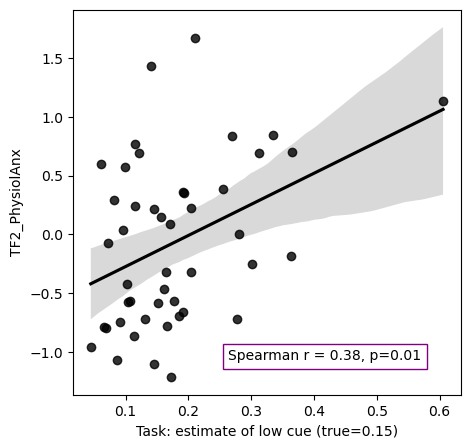

In [9]:
f, ax = plt.subplots(1,1,figsize=(5,5))
sns.regplot(data=behdf, x="prob_safe", y="TF2_PhysiolAnx", color="black")
#corrfunc(x, y, tests=["pearson"], drop_missing=False, ax=None, xanchor=0.4, yanchor = 0.1, **kws)
corrfunc(behdf["prob_safe"], behdf["TF2_PhysiolAnx"], tests=[ "spearman"], drop_missing=True, xanchor=0.4, yanchor=0.04)
ax.set_xlabel("Task: estimate of low cue (true=0.15)")

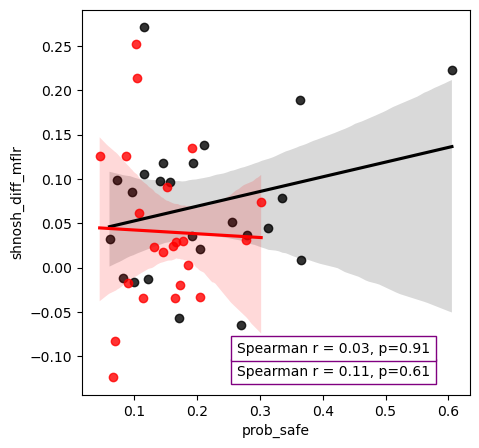

In [13]:
f, ax = plt.subplots(1,1,figsize=(5,5))
cols= ["black", "red"]
for lidx, lvl in enumerate(["high", "low"]):
    ttdf = behdf.loc[behdf["TF2_PhysiolAnx_ms"].isin([lvl])]
    sns.regplot(data=ttdf, x="prob_safe", y="shnosh_diff_mflr", color=cols[lidx], ax=ax)
    #corrfunc(x, y, tests=["pearson"], drop_missing=False, ax=None, xanchor=0.4, yanchor = 0.1, **kws)
    corrfunc(ttdf["prob_safe"], ttdf["shnosh_diff_mflr"], tests=[ "spearman"], drop_missing=True, xanchor=0.4, yanchor=0+lidx*0.06, boxcolor=cols[lidx])


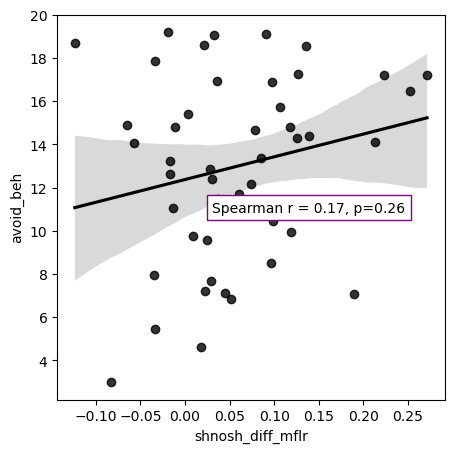

In [64]:

f, ax = plt.subplots(1,1,figsize=(5,5))
sns.regplot(data=behdf, x="shnosh_diff_mflr", y="avoid_beh", color="black")
#corrfunc(x, y, tests=["pearson"], drop_missing=False, ax=None, xanchor=0.4, yanchor = 0.1, **kws)
corrfunc(behdf["shnosh_diff_mflr"], behdf["avoid_beh"], tests=[ "spearman"], drop_missing=True, xanchor=0.4, yanchor=0.04)
#ax.set_xlabel("Task: estimate of low cue (true=0.15)")

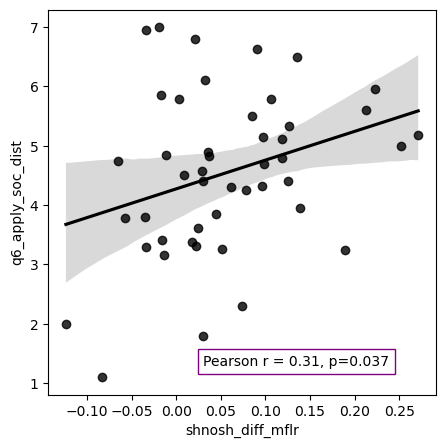

In [65]:
f, ax = plt.subplots(1,1,figsize=(5,5))
sns.regplot(data=behdf, x="shnosh_diff_mflr", y="q6_apply_soc_dist", color="black")
#corrfunc(x, y, tests=["pearson"], drop_missing=False, ax=None, xanchor=0.4, yanchor = 0.1, **kws)
corrfunc(behdf["shnosh_diff_mflr"], behdf["q6_apply_soc_dist"], tests=[ "pearson"], drop_missing=True, xanchor=0.4, yanchor=0.04)
#ax.set_xlabel("Task: estimate of low cue (true=0.15)")

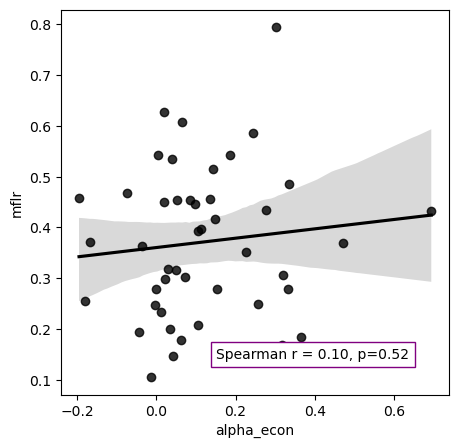

In [66]:
f, ax = plt.subplots(1,1,figsize=(5,5))
sns.regplot(data=behdf, x="alpha_econ", y="mflr", color="black")
#corrfunc(x, y, tests=["pearson"], drop_missing=False, ax=None, xanchor=0.4, yanchor = 0.1, **kws)
corrfunc(behdf["alpha_econ"], behdf["mflr"], tests=[ "spearman"], drop_missing=True, xanchor=0.4, yanchor=0.04)

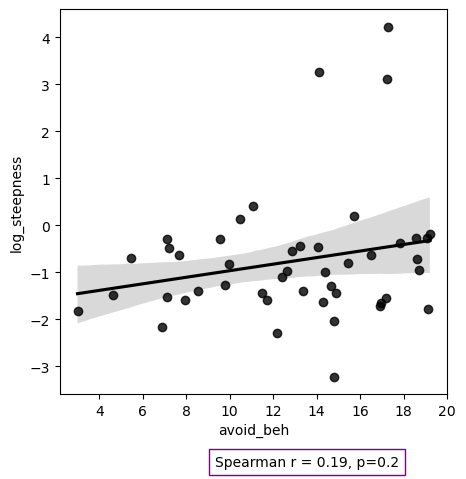

In [67]:
f, ax = plt.subplots(1,1,figsize=(5,5))
sns.regplot(data=behdf, x="avoid_beh", y="log_steepness", color="black")
#corrfunc(x, y, tests=["pearson"], drop_missing=False, ax=None, xanchor=0.4, yanchor = 0.1, **kws)
corrfunc(behdf["avoid_beh"], behdf["log_steepness"], tests=[ "spearman"], drop_missing=True, xanchor=0.4, yanchor=0.04)

### Looking at changes in behavioural task and changes throughout the pandemic

#### a/ Gather the data of changes: extinction and reinstatement (1st wave fall and 2nd wave onset)

<AxesSubplot:>

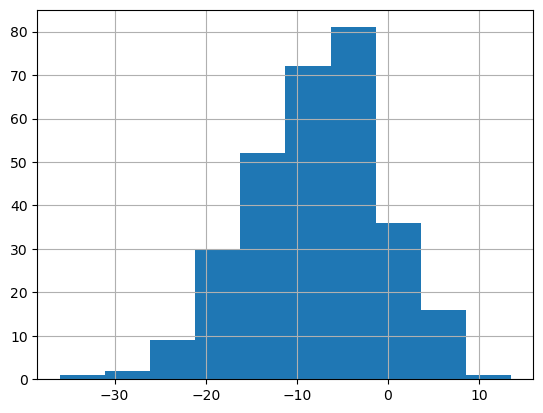

In [75]:
## variable used for aligning
var2use = "cases14_norm_unsmooth"
vars = ["q6_apply_soc_dist", "q7_avoid", "q7_covid_anxiety", "q6_media_freq_num", "q7_period_rel_danger", "q7_period_rel_safety", "q7_safety_danger_diff","prob_est", "covid_worry"]

#for v in vars:
tdf = df.groupby(by=["PROLIFICID"]).mean()[trait_factor_names].reset_index()
tdf=tdf.set_index("PROLIFICID")
for v in vars:
    trait_factor_names = ["TF3_NegativeAffect", "TF2_PhysiolAnx", "TF1_CognAnxDepr"]
    # Extract trait values for each 
    

    # get the realigned data for a variable of interest (F1 in this case)
    maxs=df.groupby(by=["PROLIFICID"])["session", v, var2use].apply(realign_time_series, 
                                                                                        var_to_align=v, 
                                                                                        var_align_by=var2use, 
                                                                                        method='cumsum-min',
                                                                                        baseline='pre-lock').reset_index()
    maxs['newsess'].replace({ 2: 'pre', 3:'pre',  8: 'post', 9: 'post', 10:'post'}, inplace=True)
    maxs = maxs.loc[maxs["newsess"].isin(['pre', 'post']),:]
    # join data sets 
    maxs = maxs.loc[:,["newsess", "PROLIFICID", v+"_realigned"]].groupby(by=["newsess", "PROLIFICID"]).mean().reset_index()
    maxs = maxs.pivot(columns="newsess", index="PROLIFICID", values=v+"_realigned")
    maxs["reinst_"+v] = maxs["post"] - maxs["pre"]

    # append
    tdf = tdf.join(maxs.loc[:,["reinst_"+v]])


    maxs=df.groupby(by=["PROLIFICID"])["session", v, var2use].apply(realign_time_series, 
                                                                                                var_to_align=v, 
                                                                                                var_align_by=var2use, 
                                                                                                method='fixed',
                                                                                                sessionfix =0,
                                                                                                baseline='lock').reset_index()
    maxs['newsess'].replace({5:'pre',  9: 'post', 10:'post'}, inplace=True)
    maxs = maxs.loc[maxs["newsess"].isin(['pre', 'post']),:]
    # join data sets 
    maxs = maxs.loc[:,["newsess", "PROLIFICID", v+"_realigned"]].groupby(by=["newsess", "PROLIFICID"]).mean().reset_index()
    maxs = maxs.pivot(columns="newsess", index="PROLIFICID", values=v+"_realigned")
    maxs["ext_"+v] =   maxs["post"] - maxs["pre"]
    # append
    tdf = tdf.join(maxs.loc[:,["ext_"+v]])
   
tdf["ext_"+v].hist()

In [73]:
## join behavioural data with dynamic data from online study 
beh_columns = ['mflr', 'updates', 'prob_harm', 'prob_safe',
       'prob_acq', 'prob_ext', 'prob_diff', 'steepness', 'switchpoint', 'meaningful', 'oddball', 'oddball_diff', 'sh_mflr', 'nosh_mflr', 'shnosh_diff_mflr']
behdf = behdf_raw.loc[:,beh_columns].join(tdf, how='left')


<AxesSubplot:>

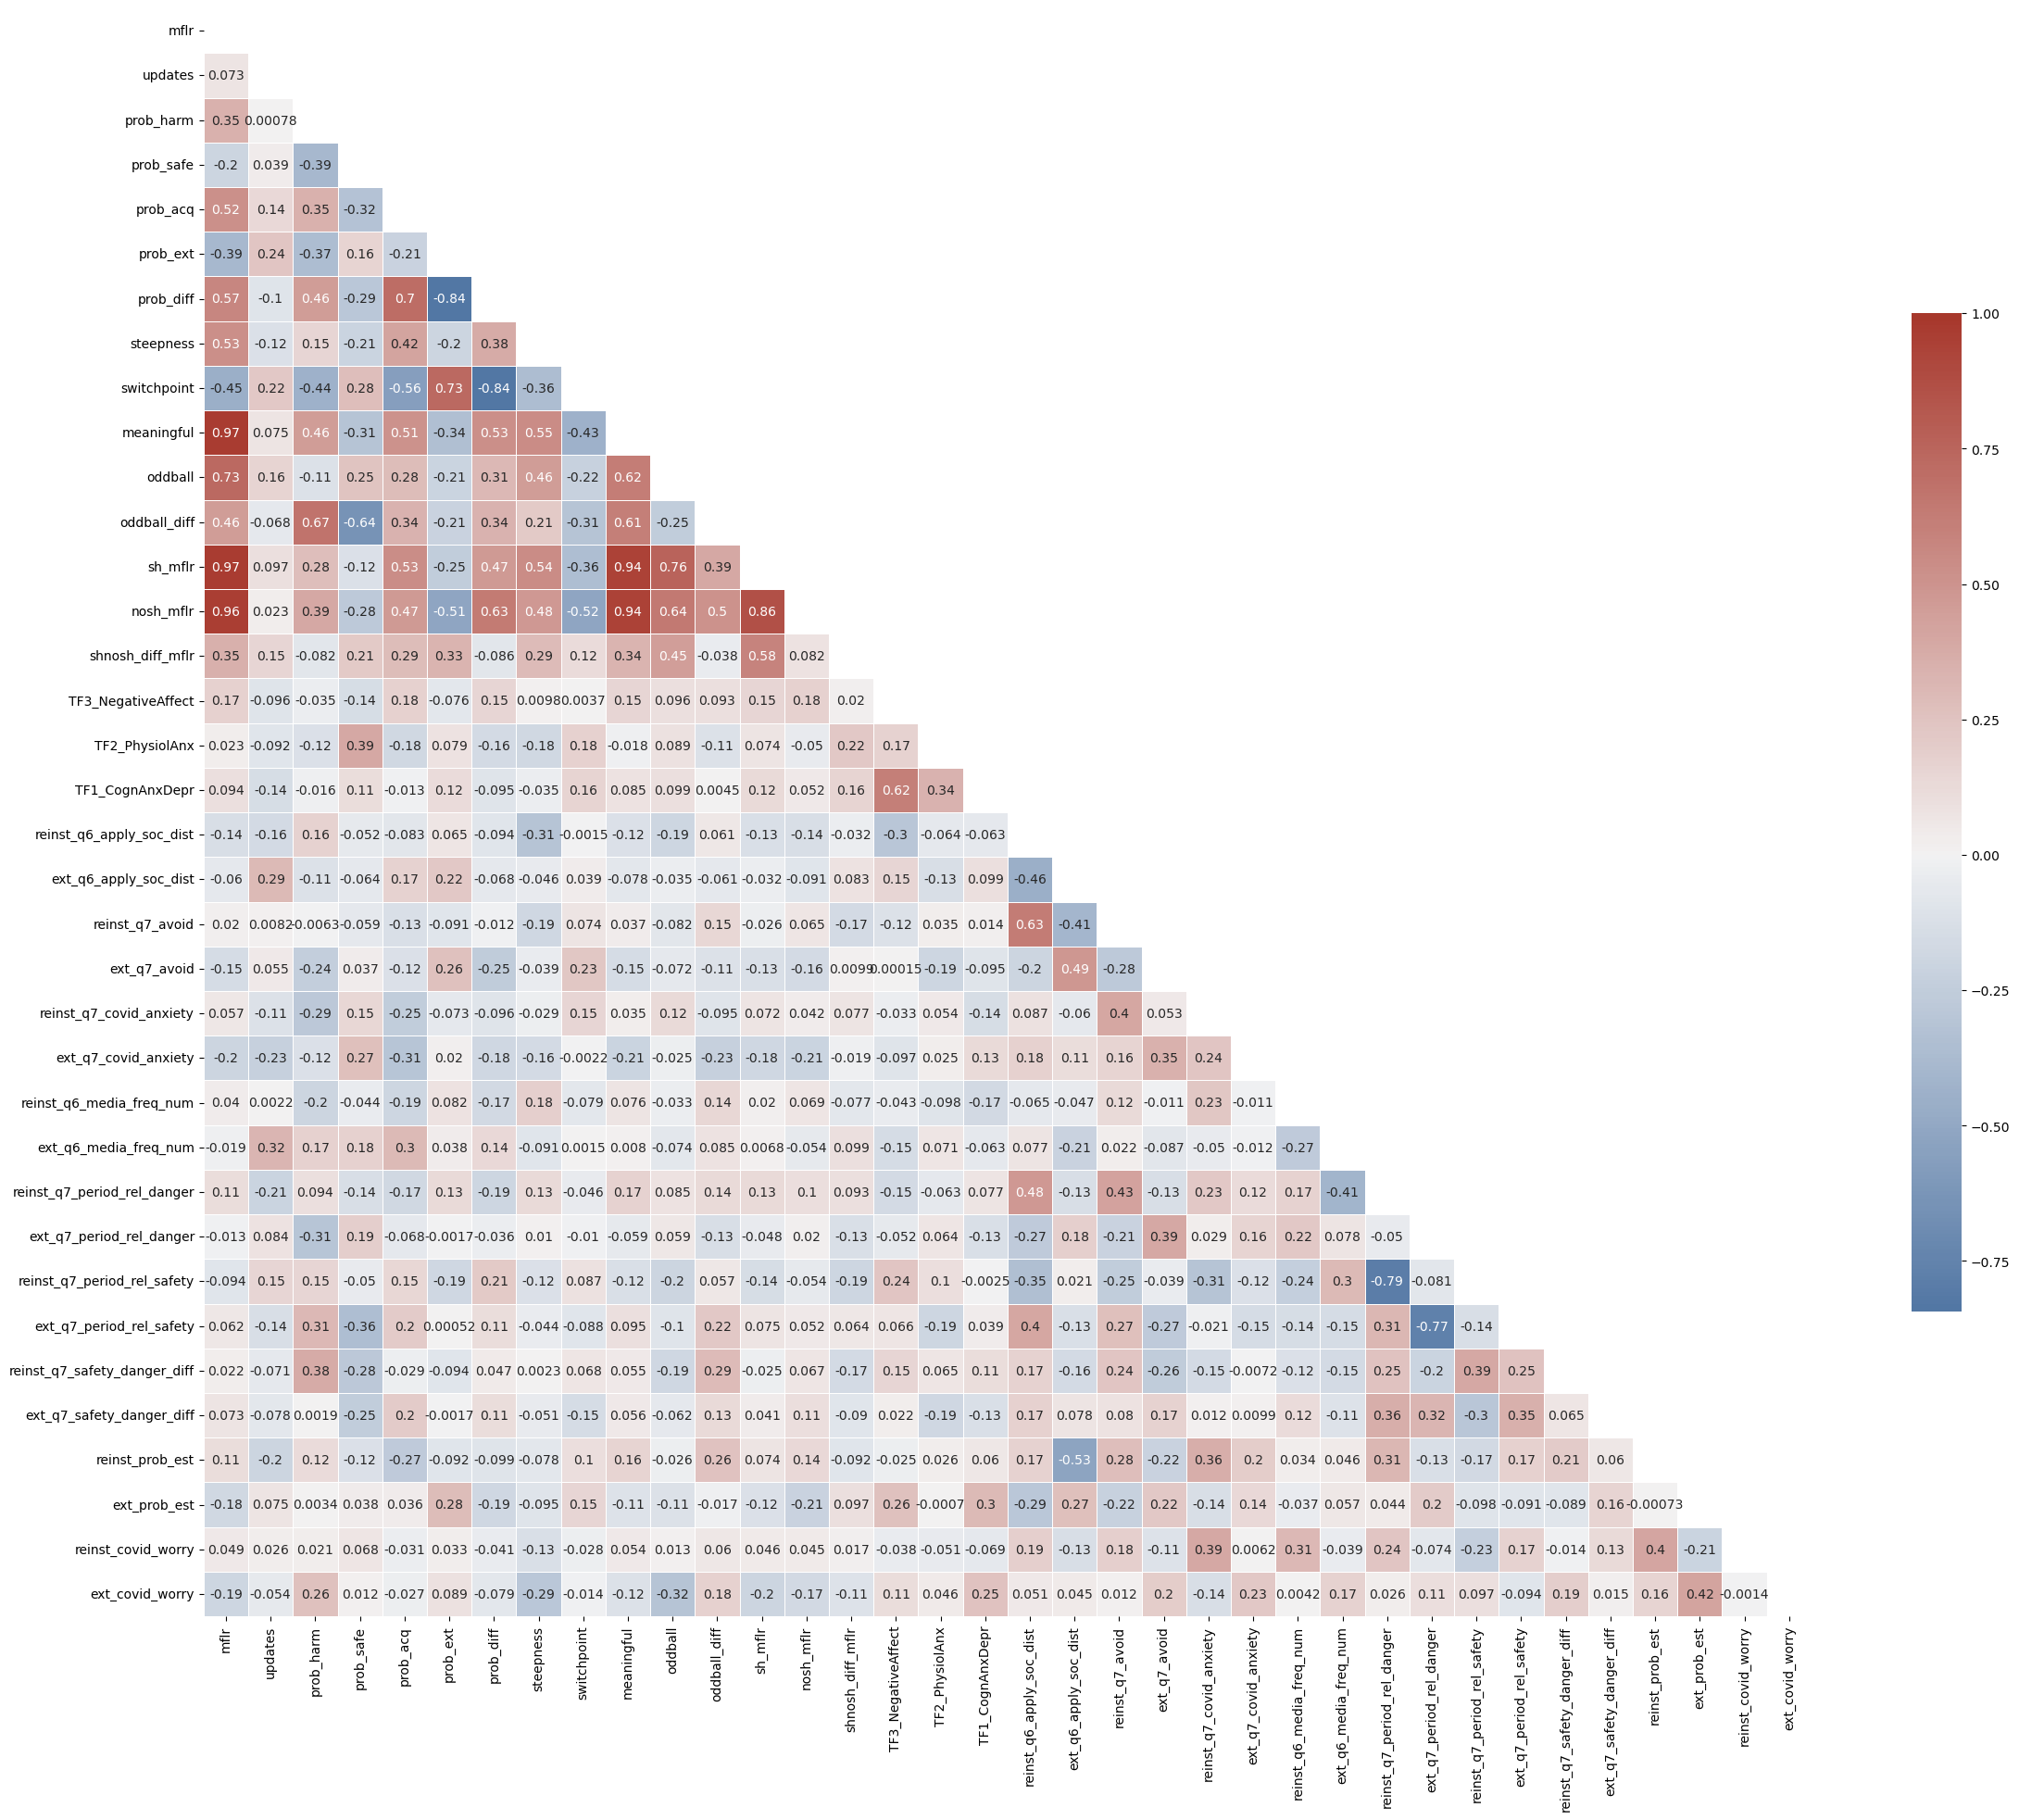

In [74]:
# calculate correlation matrix
corr = behdf.corr(corr_type)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure


# Generate a custom diverging colormap
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", 
                             as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio

f, ax = plt.subplots(1,1,figsize=(28, 28))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, annot=True,linewidths=.5, cbar_kws={"shrink": .5})

KeyError: 'reinst_q7_safety_danger_diff'

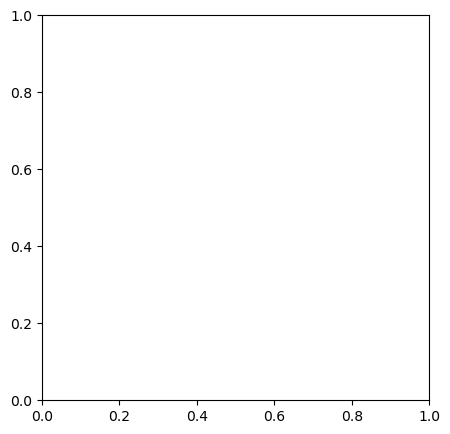

In [14]:
f, ax = plt.subplots(1,1,figsize=(5,5))
sns.regplot(data=behdf, x="reinst_q7_safety_danger_diff", y="prob_harm", color="black")
#corrfunc(x, y, tests=["pearson"], drop_missing=False, ax=None, xanchor=0.4, yanchor = 0.1, **kws)
corrfunc(behdf["reinst_q7_safety_danger_diff"], behdf["prob_harm"], tests=[ "spearman"], drop_missing=True, xanchor=0.4, yanchor=0.04)